In [1]:
import pandas as pd

# Create a DataFrame
data = pd.read_csv('./data/cleaned_data.csv')
df = pd.DataFrame(data=data)

# Display the first few rows of the DataFrame
df.head()

,SampleID,Actinobacteria,Bacteroides,Bacteroidetes,Bifidobacterium,Clostridium,Cyanobacteria,Firmicutes,Fusobacteria,Lactobacillus,Other,Prevotella,Proteobacteria,Tenericutes,Verrucomicrobia,Fiber_intake_g,Fat_intake_g,Iron_intake_mg,Serum_iron_ug
0,000007117.1075649,0.3244,0.0013,0.0315,0.0000,0.0013,0.0352,0.2629,0.0082,0.0027,0.0461,0.0028,0.2821,0.0010,0.0005,20.37,81.73,13.50,80.03
1,000007115.1075661,0.0347,0.0087,0.1735,0.0018,0.0149,0.0289,0.1783,0.0032,0.0166,0.0153,0.0025,0.5196,0.0000,0.0020,18.69,59.38,19.44,77.60
2,000007123.1075697,0.0493,0.0000,0.0153,0.0000,0.0002,0.1265,0.0451,0.0025,0.1222,0.0024,0.0007,0.6347,0.0000,0.0011,20.27,62.60,19.03,122.20
3,000009713.1130401,0.4052,0.0010,0.0091,0.0000,0.0002,0.0265,0.4219,0.0026,0.0015,0.0055,0.0062,0.1191,0.0000,0.0012,0.20,105.56,16.23,93.48
4,000005598.1130569,0.2394,0.0072,0.0401,0.0001,0.0010,0.0255,0.2582,0.0013,0.0170,0.0209,0.0024,0.3828,0.0003,0.0038,16.00,96.82,14.17,70.19


In [2]:
from sklearn.model_selection import train_test_split

target_column = 'Serum_iron_ug'

X = df.drop(columns=[target_column, "SampleID"])
y = df[target_column]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

model = BayesianRidge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

coef_df

Mean Squared Error: 552.80
R^2 Score: 0.61


,Feature,Coefficient
8,Lactobacillus,166.323647
3,Bifidobacterium,129.582587
4,Clostridium,-121.623521
9,Other,-66.690516
1,Bacteroides,52.574901
12,Tenericutes,-39.541791
11,Proteobacteria,-30.099448
13,Verrucomicrobia,-29.994660
6,Firmicutes,-29.859104
2,Bacteroidetes,-23.408445


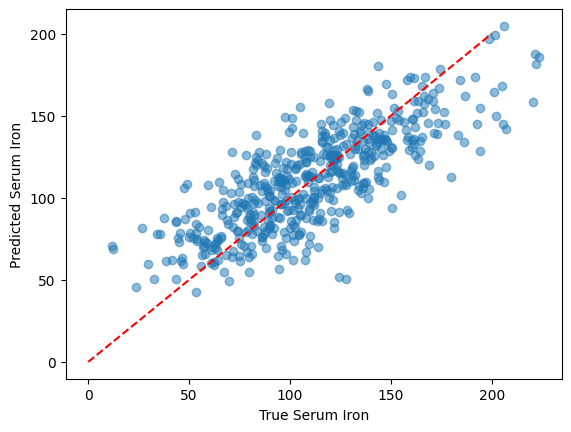

In [4]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Serum Iron")
plt.ylabel("Predicted Serum Iron")
plt.plot([0, 200], [0, 200], 'r--')  # 45-degree line
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

target_column = 'Serum_iron_ug'

X = df.drop(columns=[target_column, "SampleID"])
y = df[target_column]

# This time permute y for negative control - we want to see that the model is not overfitting
y_permuted = np.random.permutation(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_permuted, test_size=0.2, random_state=42
)

In [6]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

model = BayesianRidge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

coef_df

Mean Squared Error: 1417.29
R^2 Score: -0.01


,Feature,Coefficient
14,Fiber_intake_g,1.859282e-03
15,Fat_intake_g,-8.825094e-04
16,Iron_intake_mg,6.390868e-05
1,Bacteroides,3.606316e-05
11,Proteobacteria,-2.060797e-05
6,Firmicutes,1.526296e-05
10,Prevotella,-1.295729e-05
2,Bacteroidetes,-4.939141e-06
13,Verrucomicrobia,-4.828966e-06
8,Lactobacillus,-3.030017e-06
